In [1]:
import pandas as pd
# data = pd.read_csv('4个变量分成5类.csv',encoding = 'gb2312')
predata = pd.read_excel('iR-20210224.xlsx', sheet_name='数字数据')
data=predata
data.shape
# data.info()

(2097, 32)

In [2]:
# xdata = data[['S2','S3t1','S4','B3','B4','B5','S6','S7','S8','S11','F1',             
#       'H2','H4','H5','E4','B1s1','B1s2','B1s3','B1s4','B1s5',
#       'B1s6','B1s7','B1s8','B1s9','B1s10','B1s11','B1s12','B1s13','B1s14','B1s15',
#       'B1s16','B1s17','B1s18','B1s19','B1s20']]

# xdata1 = data[['S4','frequencyMI','frequencyTTL','totalValueMI','配件消费']]
# xdata3 = data[['S2','S3t1','S4','B3','B4','B5','S6','S7','S8','S11','F1','H2','H4','H5','E4']]
# xdata2 =  data[['S2','S3t1','S4','S7','S8','F1','B3','B4','frequencyMI','totalValueMI','配件消费']]
# print(xdata2.shape)

xdata3 = data[['frequencyMI','totalValueMI','配件消费']]
print(xdata3.shape)

# print(xdata.shape)
# print(xdata2.shape)

(2097, 3)


In [3]:
#对xdata进行标准化处理
s_raw = xdata3.apply(lambda x:(x-x.mean())/x.std())
print(s_raw.shape)
# s_raw.head()

(2097, 3)


Text(0.5, 0, 'n_components')

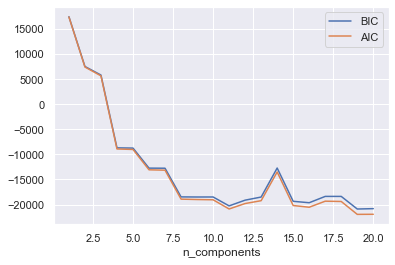

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture as GMM

## 最佳N值确定
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=555).fit(s_raw)
          for n in n_components]

plt.plot(n_components, [m.bic(s_raw) for m in models], label='BIC')
plt.plot(n_components, [m.aic(s_raw) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Automatically created module for IPython interactive environment


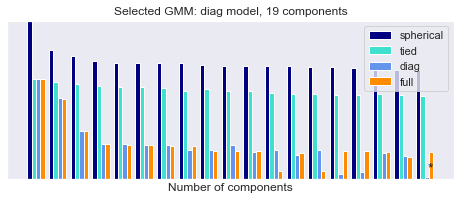

In [5]:
## GMM-成分选择2
odata=xdata3

import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture
print(__doc__)

lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(odata)
        bic.append(gmm.bic(odata))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.xticks(())
plt.yticks(())
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
          f'{best_gmm.n_components} components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [6]:
## 输出结果
k=7
gmm = GMM(n_components=k, random_state=0).fit(s_raw) #指定聚类中心个数为8
labels = gmm.predict(s_raw)

r1 = pd.Series(labels).value_counts() #统计各个类别的数目
print(r1)

r = pd.concat([xdata3, pd.Series(labels, index = xdata3.index)], axis = 1)
r.columns = list(xdata3.columns) + [u'聚类类别']
print(r)

0    646
6    591
1    374
5    215
4    166
2     55
3     50
dtype: int64
      frequencyMI  totalValueMI  配件消费  聚类类别
0               2          3250   150     1
1               1          1200   100     6
2               1            50    20     6
3               1           499     5     6
4               2           965   800     4
...           ...           ...   ...   ...
2092            1           225     0     0
2093            1           400   100     6
2094            2           231    12     1
2095            1           145    15     6
2096            2           160    25     1

[2097 rows x 4 columns]


In [ ]:
## 计算占比
# 将聚类结果带入原始数据
result_data = xdata3
result_data["label"]=r['聚类类别']
result_avg=result_data.groupby("label").mean()
result_avg=result_avg.join(result_data.label.value_counts())
result_avg["rate"]=result_avg["label"]/sum(result_avg["label"])
print(result_avg[['label','rate']])


In [22]:
data["label"]=r['聚类类别']
data.to_csv("emm.csv")

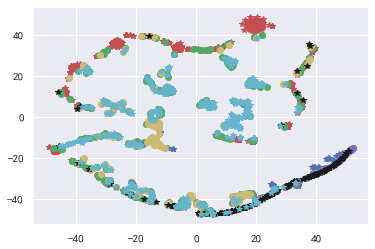

In [8]:
## 可视化
#用TSNE进行数据降维并展示聚类结果

tdata=xdata3

from sklearn.manifold import TSNE
tsne = TSNE()
tsne.fit_transform(tdata) #进行数据降维,并返回结果
tsne = pd.DataFrame(tsne.embedding_, index = tdata.index) #转换数据格式

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

#不同类别用不同颜色和样式绘图
d = tsne[r[u'聚类类别'] == 0]     #找出聚类类别为0的数据对应的降维结果
plt.plot(d[0], d[1], 'r*')
d = tsne[r[u'聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = tsne[r[u'聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
d = tsne[r[u'聚类类别'] == 3]
plt.plot(d[0], d[1], 'mo')
d = tsne[r[u'聚类类别'] == 4]
plt.plot(d[0], d[1], 'yo')
d = tsne[r[u'聚类类别'] == 5]
plt.plot(d[0], d[1], 'k*')
d = tsne[r[u'聚类类别'] == 6]
plt.plot(d[0], d[1], 'c*')
d = tsne[r[u'聚类类别'] == 7]
plt.plot(d[0], d[1], 'ko')
d = tsne[r[u'聚类类别'] == 8]
plt.plot(d[0], d[1], 'm*')
d = tsne[r[u'聚类类别'] == 9]
plt.plot(d[0], d[1], 'y*')

plt.savefig('GMM.png')
plt.show()

## 决策树

In [9]:
X = result_data.drop(['label'],axis=1)
Y = result_data['label']
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3)
print(X.shape)
print(Y.shape)
print(Xtrain.shape)
print(Xtest.shape)

(2097, 3)
(2097,)
(1467, 3)
(630, 3)


In [10]:
clf = DecisionTreeClassifier(random_state=125, splitter="random", class_weight='balanced') # 初始化
clf = clf.fit(Xtrain,Ytrain) # 拟合

# 分类准确率
score_ = clf.score(Xtest, Ytest) # 验证集查看得分
print(score_)

# 可以输入数据送到训练好的模型里，输出预测的类
y_pred = clf.predict(Xtest)
print(y_pred[:10])

#看特征变量的使用情况
# [*zip(feature_name,clf.feature_importances_)]

0.9682539682539683
[6 0 0 6 6 0 4 5 6 5]


In [17]:
#生成决策树
from sklearn.tree import DecisionTreeClassifier
#设置最大叶子数为8
dtModel = DecisionTreeClassifier(random_state=125,class_weight='balanced', max_leaf_nodes=8) 

#模型检验－交叉验证法
from sklearn.model_selection import cross_val_score
print(cross_val_score(dtModel,X,Y,cv=10).mean())

#训练模型
dtModel=dtModel.fit(X, Y) 

0.882740943267259


In [18]:
# tree模型可视化
import re
import pydotplus
from six import StringIO  #生成StringIO对象
from sklearn.tree import export_graphviz
# dot_data = StringIO() #把文件暂时写在内存的对象中
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

dot_data = export_graphviz(
    dtModel,
    out_file=None,
    class_names=['0','1','2','3','4','5','6'],
#     feature_names=['性别', '年龄', '家庭年收入', '职业', '教育水平', '种族', '宗教信仰', '上次为谁购买', '第一次演奏乐器时间', '使用乐器频率', '哪一年购买乐器',
#        '是否可以演奏多种乐器', '上次在哪里购买', '购物思考时间', '购物方式', '音乐APP', '质量','定制化','新潮','简约','传统','归属感','刺激','自然',
#         '服务','自由自在','激情','高尚','科技','活力','进取','明智购物','个人效率','古典','安逸','全面成本', '乐器的总购买数量','乐器+配件的总购买数量',
#                    '乐器的总购买金额','乐器配件总购买金额'],
    
    feature_names=['乐器数量','乐器金额','配件金额'],
#     feature_names=['S2','S3t1','S4','B2','B3','B4','B5','S6','S7','S8','S11','F1',
#       'H2','H4','H5','E1','E4','E6','U1','U3','B1s1','B1s2','B1s3','B1s4','B1s5',
#       'B1s6','B1s7','B1s8','B1s9','B1s10','B1s11','B1s12','B1s13','B1s14','B1s15',
#       'B1s16','B1s17','B1s18','B1s19','B1s20','totalValueTTL'],
    filled=True,rounded=True,special_characters=True
)

with open("dot_data.dot", 'w+', encoding="utf-8-sig") as f:  # 注意编码方式
    f.writelines(dot_data)
    
# 打开 dot_data.dot，修改 fontname="支持的中文字体"
f = open("dot_data.dot",  encoding="utf-8-sig")
open('dot_test.dot', 'w+', encoding="utf-8-sig").write(re.sub(r'fontname=helvetica', 'fontname="Microsoft YaHei"', f.read()))

with open("dot_test.dot",  encoding="utf-8-sig") as fp:
    dot_test = fp.read()
    
graph = pydotplus.graph_from_dot_data(dot_test)  #.getvalue()
graph.write_pdf('emm4-7.pdf')

True